# 1. Analyze and Process the data

In [ ]:
!git clone https://github.com/kisejin/MachineLearningBasic.git
!pip install -U pandas_profiling
!pip install -U xlrd
!pip install feature-engine
!pip install tune-sklearn ray[tune]

Cloning into 'MachineLearningBasic'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 36 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), 9.70 MiB | 6.42 MiB/s, done.


In [ ]:
# Change directory
import os
os.chdir('MachineLearningBasic/Final Project')

## Load Dataset

In [ ]:
# Library for data analysis
import pandas as pd
import numpy as np

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Library for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
                                  MinMaxScaler, StandardScaler
from feature_engine.outliers import Winsorizer

# Library for model
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Library for evaluate model
from sklearn.metrics import classification_report,\
                            f1_score, \
                            accuracy_score,\
                            recall_score,\
                            precision_score, confusion_matrix

# Library for optimize training
from tune_sklearn import TuneGridSearchCV
from joblib import parallel_backend
from ray.util.joblib import register_ray

In [ ]:
pd.set_option("display.max_columns",None)

In [ ]:
df=pd.read_csv('Banking.csv')
df.head(10)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
5,10000006,"4,500",2 years,Rent,30000.0,VERIFIED - income source,credit_card,10.88,1,NaN,12,15,Male,3
6,10000007,"18,075",4 years,Rent,85000.0,VERIFIED - income,debt_consolidation,5.65,0,NaN,9,12,Male,3
7,10000008,"15,000",< 1 year,Rent,115000.0,VERIFIED - income,debt_consolidation,7.97,1,16.0,25,31,Female,2
8,10000009,"6,300",10+ years,Rent,NaN,not verified,debt_consolidation,16.12,3,NaN,8,9,Female,3
9,10000010,"30,000",10+ years,Own,163000.0,VERIFIED - income,debt_consolidation,11.13,0,NaN,24,43,Male,1


## Data Analysis

### Kiểm tra datatype của các features cũng kiểm tra xem có giá trị null hay không
Dữ liệu có giá trị null nên cần phải xử lý

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

### Kiểm tra giá trị null

In [ ]:
df.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

Có thể thấy các cột ``Length_Employed``,``Honme_Owner``,``Annual_Income``,``Months_Since_Deliquency`` có xuất hiện giá trị ``NA``

Một số cột có datatype không đúng định dạng, nên ở phần Preprocessing em sẽ covert về đúng kiểu datatype của nó

## Preprocessing

Drop những columns có thể thấy hiển nhiên là không mang lại giá trị cho việc dự đoán (như `Loan_ID `, `Gender`,..)

In [ ]:
columns_to_drop=['Loan_ID','Gender']
df.drop(columns=columns_to_drop,axis=1,inplace=True)
df.head(5)

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
0,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,1
1,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,3
2,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,3
3,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,3
4,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,1


Kiểm tra thử shape của df trước vào sau khi drop na (vì không cho tham số `inplace = True` nên df vẫn không thay đổi)

In [ ]:
print(df.shape)
print(df.dropna().shape)

(164309, 12)
(51966, 12)


Có thể thấy sau khi dropna thì số lượng samples giảm xuống rất nhiều, mất rất nhiều dữ liệu nên em sẽ không dropna mà sẽ fillna (trình bày trong phần feature engineering)

Đếm giá trị của các cột có định dạng là `object` (thường là categorical feature)

In [ ]:
for cat in df.select_dtypes('object') :
    print(df[cat].value_counts())

10,000    11622
12,000     9018
15,000     8459
20,000     7993
35,000     5844
          ...  
29,650        1
32,450        1
26,425        1
27,950        1
29,825        1
Name: Loan_Amount_Requested, Length: 1290, dtype: int64
10+ years    52915
2 years      14620
3 years      12974
< 1 year     12805
5 years      10814
1 year       10422
4 years       9784
7 years       9308
6 years       9094
8 years       7917
9 years       6285
Name: Length_Employed, dtype: int64
Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64
VERIFIED - income           59421
VERIFIED - income source    53015
not verified                51873
Name: Income_Verified, dtype: int64
debt_consolidation    97101
credit_card           36684
home_improvement       9269
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation    

Nhận xét :

* Cột `Loan_Amount_Requested`,`Length_Employed` phải chuyển về dạng `numeric`
* Cột `Purpose_Of_Loan` có khá nhiều giá trị khác nhau nên phải cân nhắc khi encoding

Chuyển cột `Loan_Amount_Requested` về dạng `float64`

In [ ]:
df['Loan_Amount_Requested']=df['Loan_Amount_Requested'].str.replace(',','').astype('float64')
df['Loan_Amount_Requested']

0          7000.0
1         30000.0
2         24725.0
3         16000.0
4         17000.0
           ...   
164304    20725.0
164305     6000.0
164306    20250.0
164307    10000.0
164308     9250.0
Name: Loan_Amount_Requested, Length: 164309, dtype: float64

Chuyển cột `Length_Employed` về dạng `Int64` (`Int64` khác `int64` ở việc có thể convert mà bỏ qua giá trị `NA`, còn lại không có gì khác biệt)
Với các giá trị `< 1 year` em sẽ cho = `0`, còn các giá trị `10+ years` em sẽ cho = `10`

In [ ]:
df.loc[df['Length_Employed']=='< 1 year',['Length_Employed']]='0 year'
df['Length_Employed']=df['Length_Employed'].str.replace(r'[^0-9]','',regex=True).astype('Int64')
df['Length_Employed']

0          0
1          4
2          7
3          0
4          8
          ..
164304    10
164305     8
164306    10
164307     4
164308    10
Name: Length_Employed, Length: 164309, dtype: Int64

Chia các features thành các biến định tính (categorical) hoặc định lượng (numeric), vì `Purpose_Of_Loan` có khá nhiều giá trị nên em sẽ tách riêng để xử lý

In [ ]:
# Categorical Feauture
cat_features=df.iloc[:,:-1].select_dtypes(include='object').columns.drop(labels='Purpose_Of_Loan')
# Numeric Feauture
num_features=df.iloc[:,:-1].select_dtypes(exclude='object').columns
# Purpose_Of_Loan
hashing_feature= pd.Index(['Purpose_Of_Loan'])

print(cat_features)
print(num_features)
print(hashing_feature)

Index(['Home_Owner', 'Income_Verified'], dtype='object')
Index(['Loan_Amount_Requested', 'Length_Employed', 'Annual_Income',
       'Debt_To_Income', 'Inquiries_Last_6Mo', 'Months_Since_Deliquency',
       'Number_Open_Accounts', 'Total_Accounts'],
      dtype='object')
Index(['Purpose_Of_Loan'], dtype='object')


Kiểm tra lại giá trị của các biến định tính (categorical features)

In [ ]:
for col in cat_features:
    print(df[col].value_counts(dropna=False))
    print()

Mortgage    70345
Rent        56031
NaN         25349
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

VERIFIED - income           59421
VERIFIED - income source    53015
not verified                51873
Name: Income_Verified, dtype: int64



In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
df.describe()

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,164309.00000,156938.0,1.392070e+05,164309.000000,164309.000000,75930.000000,164309.000000,164309.000000,164309.000000
mean,14349.33692,5.993201,7.333116e+04,17.207189,0.781698,34.229356,11.193818,25.067665,2.158951
std,8281.86870,3.628592,6.037750e+04,7.845083,1.034747,21.761180,4.991813,11.583067,0.738364
min,500.00000,0.0,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,8000.00000,3.0,4.500000e+04,11.370000,0.000000,16.000000,8.000000,17.000000,2.000000
50%,12075.00000,6.0,6.300000e+04,16.840000,0.000000,31.000000,10.000000,23.000000,2.000000
75%,20000.00000,10.0,8.869750e+04,22.780000,1.000000,50.000000,14.000000,32.000000,3.000000
max,35000.00000,10.0,7.500000e+06,39.990000,8.000000,180.000000,76.000000,156.000000,3.000000


## Data visualization

Biểu đồ countplot cho biến mục tiêu

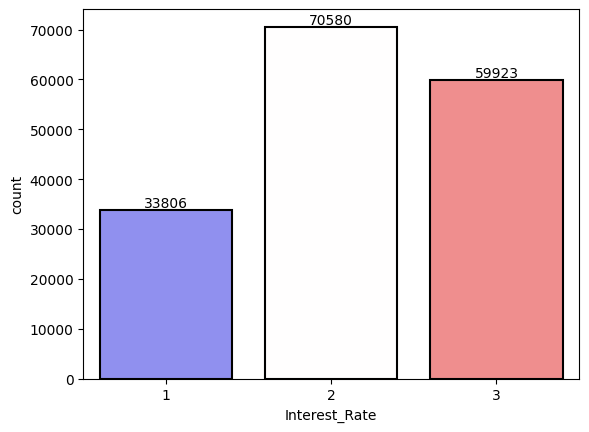

In [ ]:
ax = sns.countplot(x="Interest_Rate", data=df, palette="bwr",
                   linewidth=1.5, edgecolor='black')
for label in ax.containers:
    ax.bar_label(label)

plt.show()


Có thể thấy theo mô tả thì `churn_risk_score` từ 1 đến 3 và phân bố khá cân bằng (không có sự mất cân bằng quá nghiêm trọng)

Biểu đồ histogram cho biến numeric

array([[<Axes: title={'center': 'Loan_Amount_Requested'}>,
        <Axes: title={'center': 'Length_Employed'}>,
        <Axes: title={'center': 'Annual_Income'}>],
       [<Axes: title={'center': 'Debt_To_Income'}>,
        <Axes: title={'center': 'Inquiries_Last_6Mo'}>,
        <Axes: title={'center': 'Months_Since_Deliquency'}>],
       [<Axes: title={'center': 'Number_Open_Accounts'}>,
        <Axes: title={'center': 'Total_Accounts'}>, <Axes: >]],
      dtype=object)

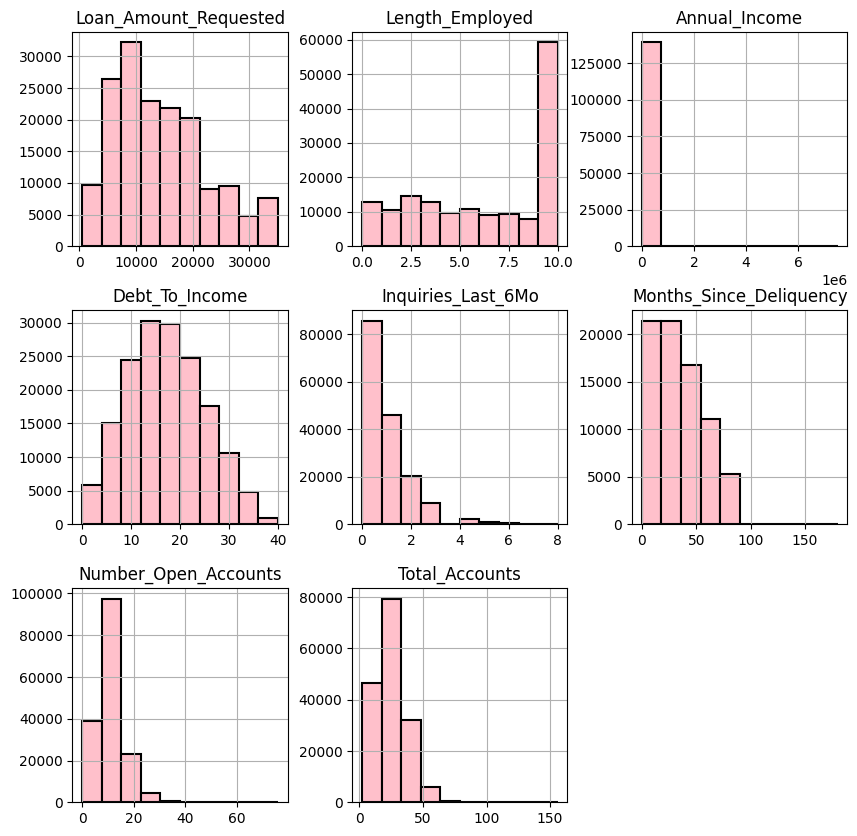

In [ ]:
df.hist(column=num_features, figsize=(10, 10),
        edgecolor='black', color='pink', linewidth=1.5)

Biểu đồ boxplot

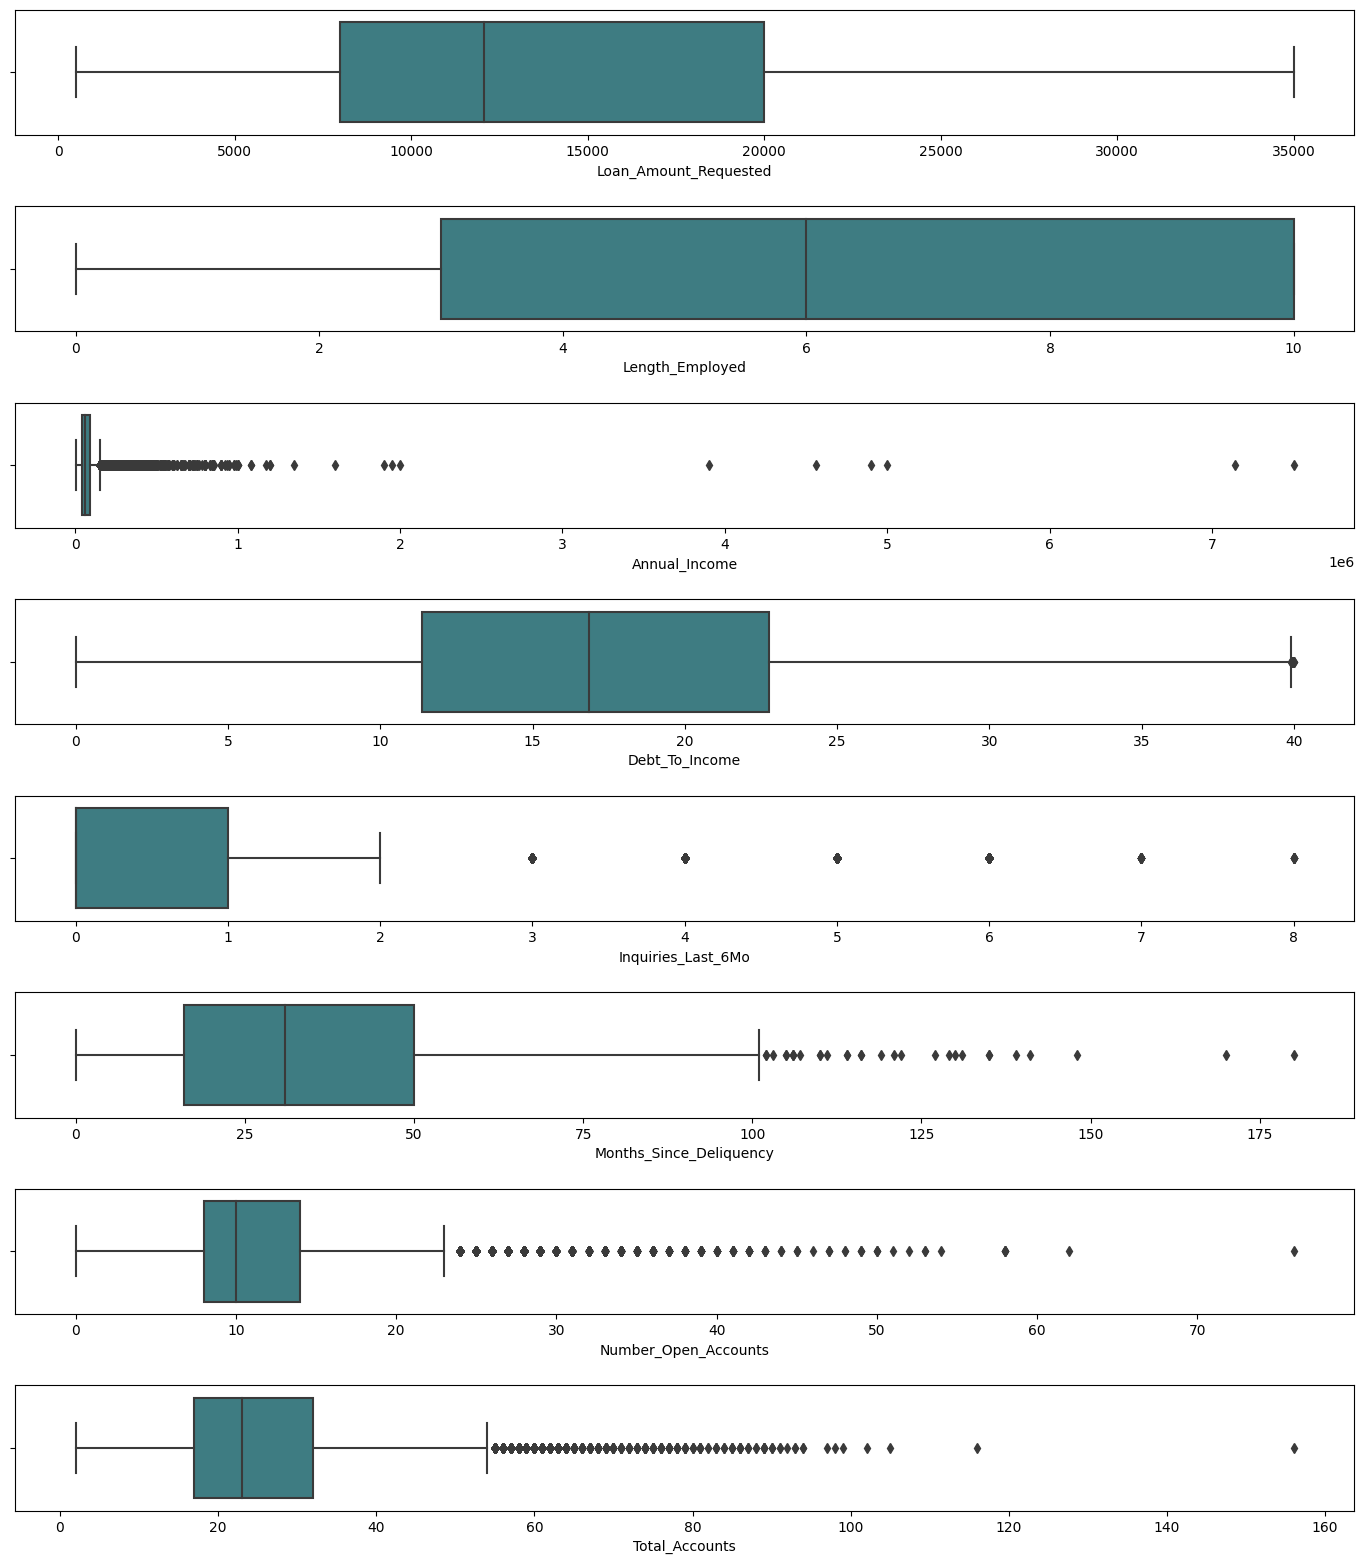

In [ ]:
box_cols = num_features
fig, axes=plt.subplots(len(box_cols), 1, figsize=(14, 2*len(box_cols)),sharex=False,sharey=False)

for i, column in enumerate(box_cols):
    sns.boxplot(x=column,data=df,palette='crest',ax=axes[i])
plt.tight_layout(pad=2.0)

Biểu đồ histogram

Biểu đồ countplot cho biến category

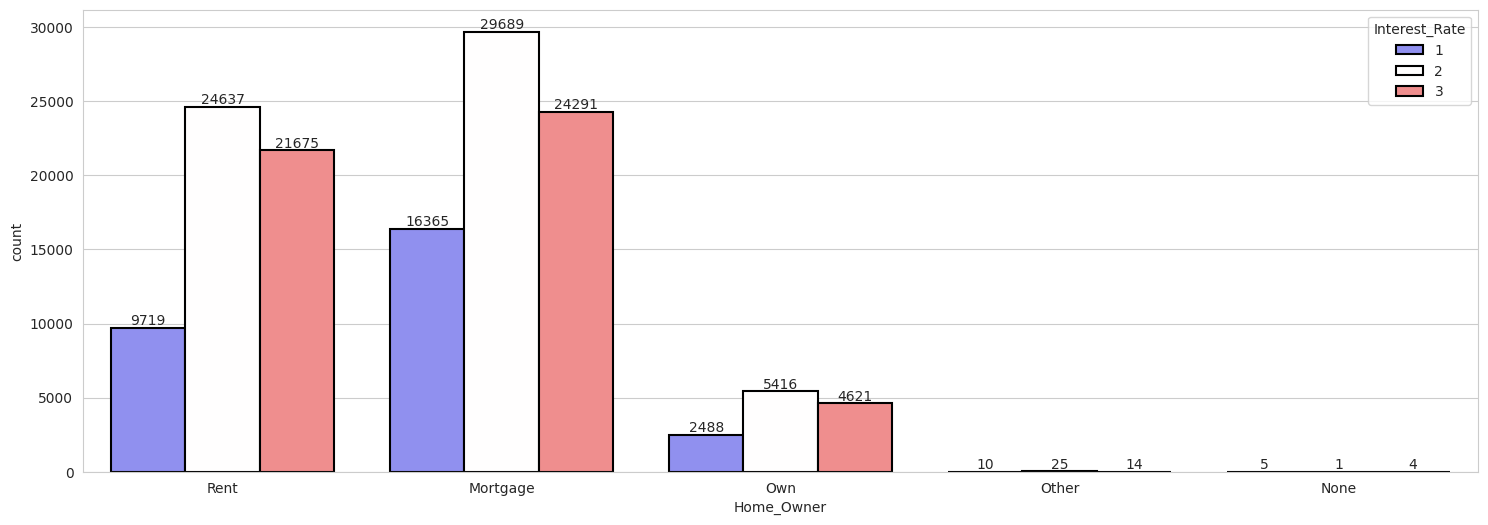

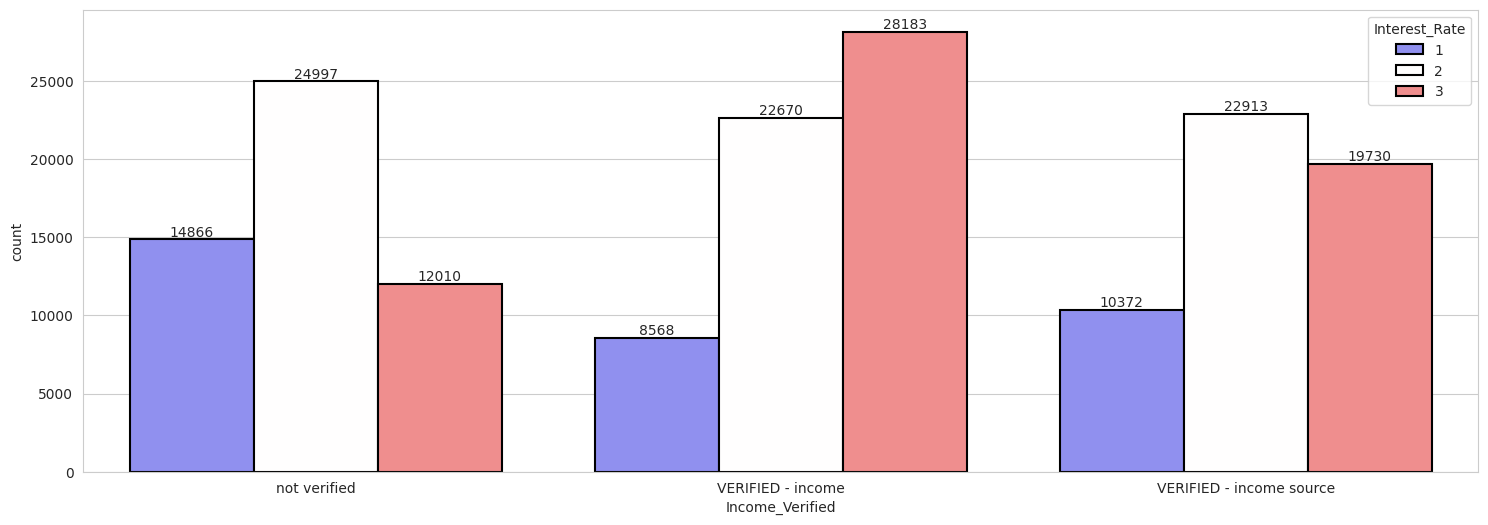

In [ ]:
for i, cat_feature in enumerate(cat_features):
    plt.figure(figsize=(18,6))
    ax=sns.countplot(x=cat_feature, data=df, palette="bwr",
                   hue='Interest_Rate', linewidth=1.5, edgecolor='black')
    for label in ax.containers:
        ax.bar_label(label)

Hàm tạo feature và target

In [ ]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    X =  df[df.columns[:-1]]
    y =  df[df.columns[-1]]
    return X, y

X, y = prepare_X_y(df)


Chia train, test set

In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 20
TRAIN_SIZE = 0.75
trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE,stratify=y)

Các phần như feature engineering hay sampling đều được xây dựng trong pipeline nên em sẽ gộp chung các phần này vào phần xây dựng mô hình

# 2. Feature engineering
# 3. Sampling Your Data
# 4. Build Model
# 5. Perform model on training set and test set using gridsearch CV
# 6. Measure performance of the model.

In [ ]:
np.set_printoptions(suppress=True)

## Xây dựng hàm build_model

In [ ]:
def build_model(X, y,pipeline, param_grid):

    # Tạo GridSearchCV
    grid_search = TuneGridSearchCV(
        pipeline,  # Mô hình được sử dụng
        param_grid,  # Các tham số cần tìm kiếm
        cv=5,  # Số lượng fold trong cross-validation
        scoring='f1_weighted',  # Độ đo sử dụng để đánh giá mô hình
        n_jobs = -1, # Sử dụng tài nguyên chưa sử dụng để train model
        return_train_score=True, # Trả về score trong quá trình training với tham số dược fine-tuning
    )

    register_ray()
    with parallel_backend("ray"):
      grid_search.fit(X, y)
    return grid_search


## Xây dựng Pileline

In [ ]:
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputer(strategy='mean')),
            ('outlier', Winsorizer(capping_method = 'gaussian', tail = 'both',
                                      fold = 3)),
            ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist"))
    ]
)
hashing_transformer =Pipeline(
    steps=[
        ("inputer",SimpleImputer(strategy='most_frequent')),
        ("encoder",FeatureHasher(n_features=5,input_type='string'))
    ]
)
# Tạo đối tượng preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,num_features),
        ("cat", categorical_transformer, cat_features),
        ("hashing",hashing_transformer,hashing_feature)
    ]
)


## Mô hình Multilayer Perceptron (MLPClassifier)

In [ ]:
estimator= MLPClassifier()

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__hidden_layer_sizes":[50,100,200]
}

model = build_model(trainX, trainY,pipeline,param_grid)
model.fit(trainX, trainY)

# Compare on training dataset
pred = model.predict(trainX)
print('Train : \n')
print(classification_report(trainY,pred))
pred = model.predict(testX)
print('Test : \n')
print(classification_report(testY,pred))
print(f'Best score: {f1_score(testY, pred, average = "weighted")}')

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(
(_Trainable pid=8680) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(_Trainable pid=8680)   warnings.warn(
(_Trainable pid=8692)   warnings.warn(
(_Trainable pid=8692)   warnings.warn(
(_Trainable pid=8680) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(_Trainable pid=8680)   warnings.warn(
(_Trainable pid=8692)   warnings.warn(
(_Trainable pid=8692)   warnings.warn(
(_Trainable pid=8680) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of

Train : 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       872
           1       0.57      0.88      0.69      1989
           2       0.76      0.40      0.53      2056
           3       0.82      0.86      0.84      7818
           4       0.68      0.33      0.45      7639
           5       0.64      1.00      0.78      7370

    accuracy                           0.69     27744
   macro avg       0.58      0.58      0.55     27744
weighted avg       0.68      0.69      0.66     27744

Test : 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       291
           1       0.55      0.88      0.68       663
           2       0.73      0.36      0.48       685
           3       0.81      0.86      0.84      2606
           4       0.67      0.32      0.44      2546
           5       0.64      1.00      0.78      2457

    accuracy                           0.69      9248
   m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


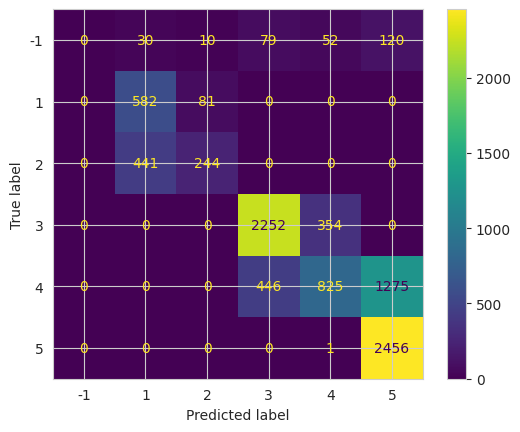

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY,pred),display_labels=model.classes_).plot()

## Mô hình Logistic Regression

In [ ]:
estimator = LogisticRegression()
# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10]
}

model1 = build_model(trainX, trainY,pipeline,param_grid)
# Compare on training dataset
pred = model1.predict(trainX)
print('Train : \n')
print(classification_report(trainY,pred))
pred = model1.predict(testX)
print('Test : \n')
print(classification_report(testY,pred))
print(f'Best parameter : {model1.best_params_}')
print(f'Best score: {f1_score(testY, pred, average = "weighted")}')

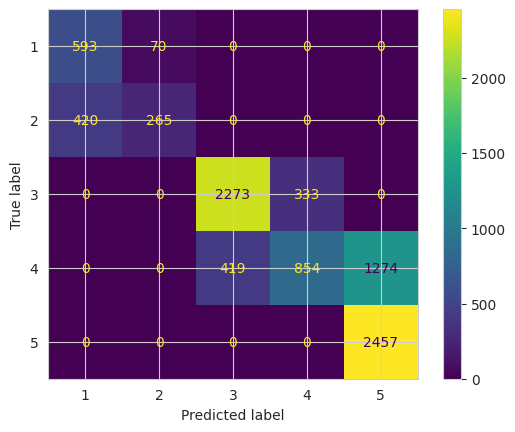

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY,pred),display_labels=model1.classes_).plot()

## Mô hình Random Forest

In [ ]:
estimator= RandomForestClassifier
# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__n_estimators":[50,100,200]
}

model2 = build_model(trainX, trainY,pipeline,param_grid)
# Compare on training dataset
pred = model2.predict(trainX)
print('Train : \n')
print(classification_report(trainY,pred))
pred = model2.predict(testX)
print('Test : \n')
print(classification_report(testY,pred))
print(f'Best parameter : {model2.best_params_}')
print(f'Best score: {f1_score(testY, pred, average = "weighted")}')

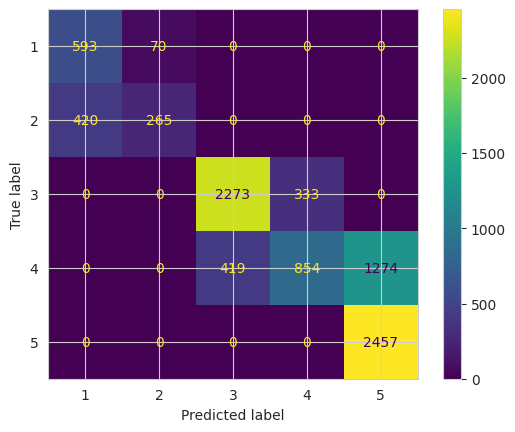

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY,pred),display_labels=model2.classes_).plot()

## Mô hình SVC với rbf kernel

In [ ]:
estimator=SVC(tol=1e-2, class_weight = 'balanced')

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10,100],
}

model3 = build_model(trainX, trainY,pipeline,param_grid)
# Compare on training dataset
pred = model3.predict(trainX)
print('Train : \n')
print(classification_report(trainY,pred))
pred = model3.predict(testX)
print('Test : \n')
print(classification_report(testY,pred))
print(f'Best parameter : {model3.best_params_}')
print(f"Best score: {f1_score(testY, pred, average = 'weighted')}")

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(


Train : 

              precision    recall  f1-score   support

           1       0.58      0.93      0.71      1989
           2       0.84      0.34      0.48      2056
           3       0.92      0.88      0.90      7818
           4       0.77      0.42      0.55      7638
           5       0.66      1.00      0.79      7370

    accuracy                           0.74     26871
   macro avg       0.75      0.71      0.69     26871
weighted avg       0.77      0.74      0.72     26871

Test : 

              precision    recall  f1-score   support

           1       0.57      0.92      0.71       663
           2       0.82      0.33      0.47       685
           3       0.90      0.86      0.88      2606
           4       0.74      0.40      0.52      2547
           5       0.66      1.00      0.79      2457

    accuracy                           0.73      8958
   macro avg       0.74      0.70      0.67      8958
weighted avg       0.76      0.73      0.71      8958

Bes

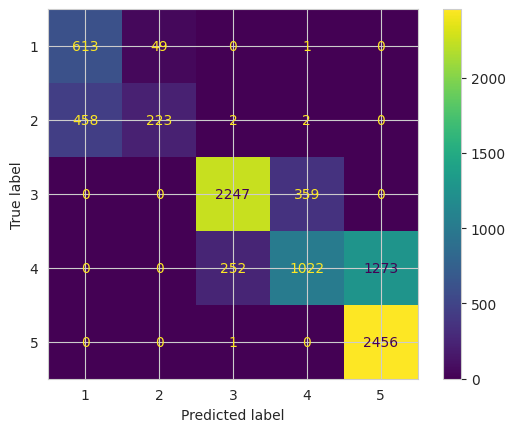

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY,pred),display_labels=model3.classes_).plot()

# 7. Conclusion

* Vì trường hợp multiclass và các class có support chênh lệch nhau nhiều nên em sử dụng f1_weighted là main score để đánh giá mô hình

* Trong tất cả các mô hình thì chủ yếu là giữa Class 1 và 2, 4 và 5 bị miss classified khá nhiều , còn lại các mô hình dự đoán khá tốt

* Thời gian chạy SVC tăng phi tuyến với số lượng samples, vì dữ liệu khá lớn nên sẽ mất nhiều thời gian để training

* Vì kết quả dự đoán class -1 rất thấp (=0), có nghĩa là các features không có ý nghĩa trong việc dự đoán class -1. Có thể class -1 là sai sót trong quá trình thu thập dữ liệu, hoặc có thể là vì một lý do nào đó. Hoặc -1 là giá trị mặc định khi khách hàng không đánh giá sản phẩm.

* Kết quả nhân được:

| Model | Score |
| :--- | :--- |
| 1. Linear SVC | 0.99 |
| 2. SGD Linear SVC | 0.54 |
| 3. RBF SVC | 0.69 |
| 4. Polynomial SVC | 0.7 |